# Evaluation of ADMM on multiple subject of fMRI data

Copyright (c) 2024 University of Strasbourg
Author: Massyl Moudoud <mmoudoud@unistra.fr> 
Contributor(s) : Céline Meillier <meillier@unistra.fr>, Vincent Mazet <vincent.mazet@unistra.fr>

This work has been supported by the ANR project DynaSTI: ANR-22-CE45-0008

This software is governed by the CeCILL  license under French law and
abiding by the rules of distribution of free software.  You can  use, 
modify and/ or redistribute the software under the terms of the CeCILL
license as circulated by CEA, CNRS and INRIA at the following URL
"http://www.cecill.info". 

As a counterpart to the access to the source code and  rights to copy,
modify and redistribute granted by the license, users are provided only
with a limited warranty  and the software's author,  the holder of the
economic rights,  and the successive licensors  have only  limited
liability. 

In this respect, the user's attention is drawn to the risks associated
with loading,  using,  modifying and/or developing or reproducing the
software by the user in light of its specific status of free software,
that may mean  that it is complicated to manipulate,  and  that  also
therefore means  that it is reserved for developers  and  experienced
professionals having in-depth computer knowledge. Users are therefore
encouraged to load and test the software's suitability as regards their
requirements in conditions enabling the security of their systems and/or 
data to be ensured and,  more generally, to use and operate it in the 
same conditions as regards security. 

The fact that you are presently reading this means that you have had
knowledge of the CeCILL license and that you accept its terms.

In [1]:
#imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
import itertools
#To load ROIs info
import csv

functionPath = "../src"
sys.path.append(functionPath)

from utile.correlation_matrix_vectorization import build_C_vectors 
from utile.plot_results_ADMM import plot_results 
from Preprocessing.load_data import load_fMRI_data
from Preprocessing.sliding_correlation import list_of_corr_matrices
from joint_estimation_A_D.joint_optimization_A_D_ADMM import joint_estimation_A_D

In [2]:
path = "../data/fMRI_timecourses"
TC_data , D_tilde = load_fMRI_data(path)
#get shape of data
R , T = TC_data[0].shape

In [3]:
#keep only active pairs inD
active_pairs = np.sum(D_tilde , axis=1)>0
D_tilde = D_tilde[active_pairs, :]

In [4]:
# Get correlation matrices
#get correlation matrix
lenW = 55 #window length

#create the window
window = np.ones(lenW)
win = np.convolve(window,sp.signal.windows.gaussian(lenW, std=3), mode = 'same')
window = win/np.max(win)


C_lists = list()
Cvec_list = list()

for TC in TC_data:
    C_list = list_of_corr_matrices(TC, window, step = 1)
    C_lists.append(C_list)
    #Cvec contains only active pairs of ROI
    Cvec_list.append(build_C_vectors(R,C_list)[active_pairs, :])
    
E , N_windows = Cvec_list[0].shape

# Run optimization

In [327]:
#set parameters of ADMM

max_iter = 30

#set parameter for A step
lambda_L1= 0.1
maxIter_A= 3000
mu= 1
lambda_TV= 0



#set parameters for D step
maxIter_D = 50#maximum number of iterations
rho = 0.1 #regularization parameter (and learning rate)

param_A = { "lambda_l1" : lambda_L1, "AL_iters" : maxIter_A, "mu" : mu, 
           "lambda_TV" : lambda_TV , "verbose" : False} 

param_D = {"rho" : rho , "maxIter" : maxIter_D}


#run ADMM for each mouse
results_list = []

for Cvec in Cvec_list:
    D_est , A_est , err = joint_estimation_A_D(Cvec, D_tilde, max_iter,  param_D , param_A , True)
    C_est = D_est@A_est
    res_dict = {'A_est': A_est , 'D_est' : D_est , 'C_est': C_est, "err" : err}
    results_list.append(res_dict)


0
10
20
0
10
20
0
10
20
0
10
20
0
10
20
0
10
20
0
10
20
0
10
20


In [328]:
np.save("./optimization_results/fMRI/estimation_multisubjects.npy", results_list)

In [5]:
results_list = np.load("./optimization_results/fMRI/estimation_multisubjects.npy" , allow_pickle=True)

/tmp/ipykernel_21272/2612611608.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(layout ="constrained")


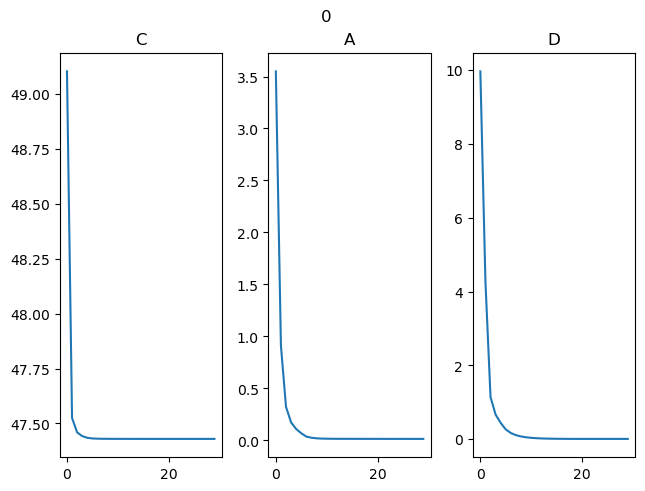

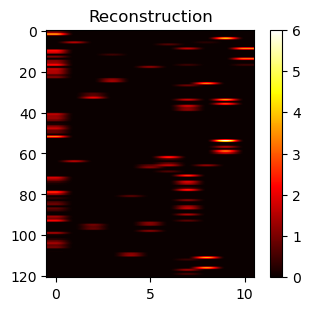

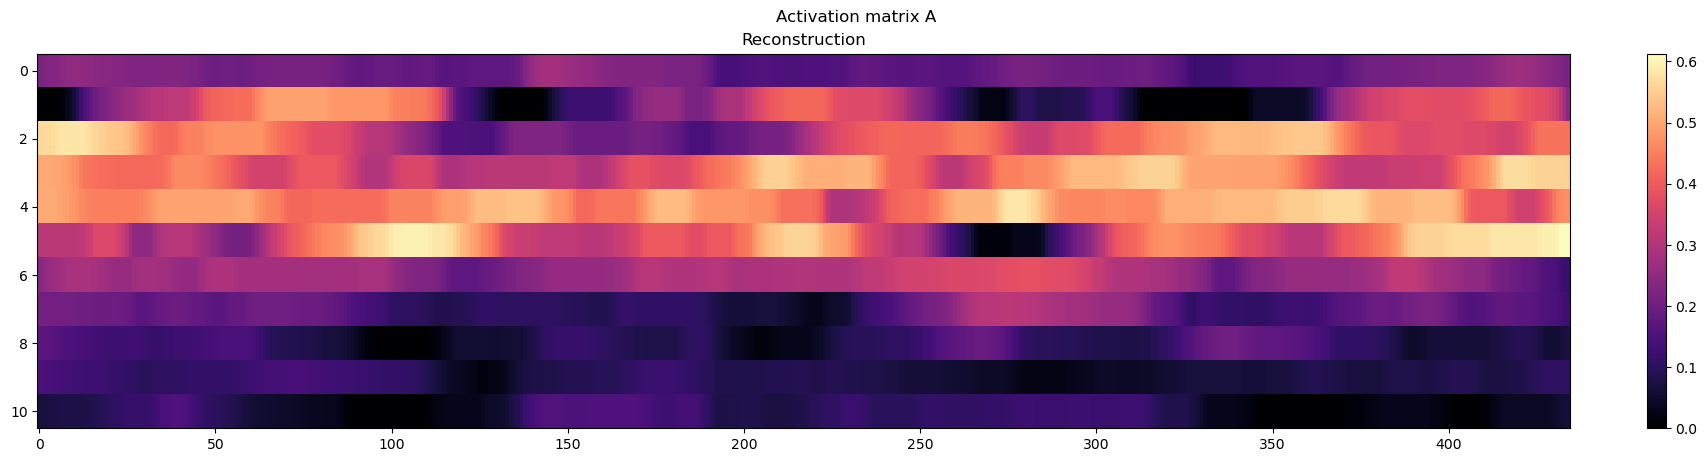

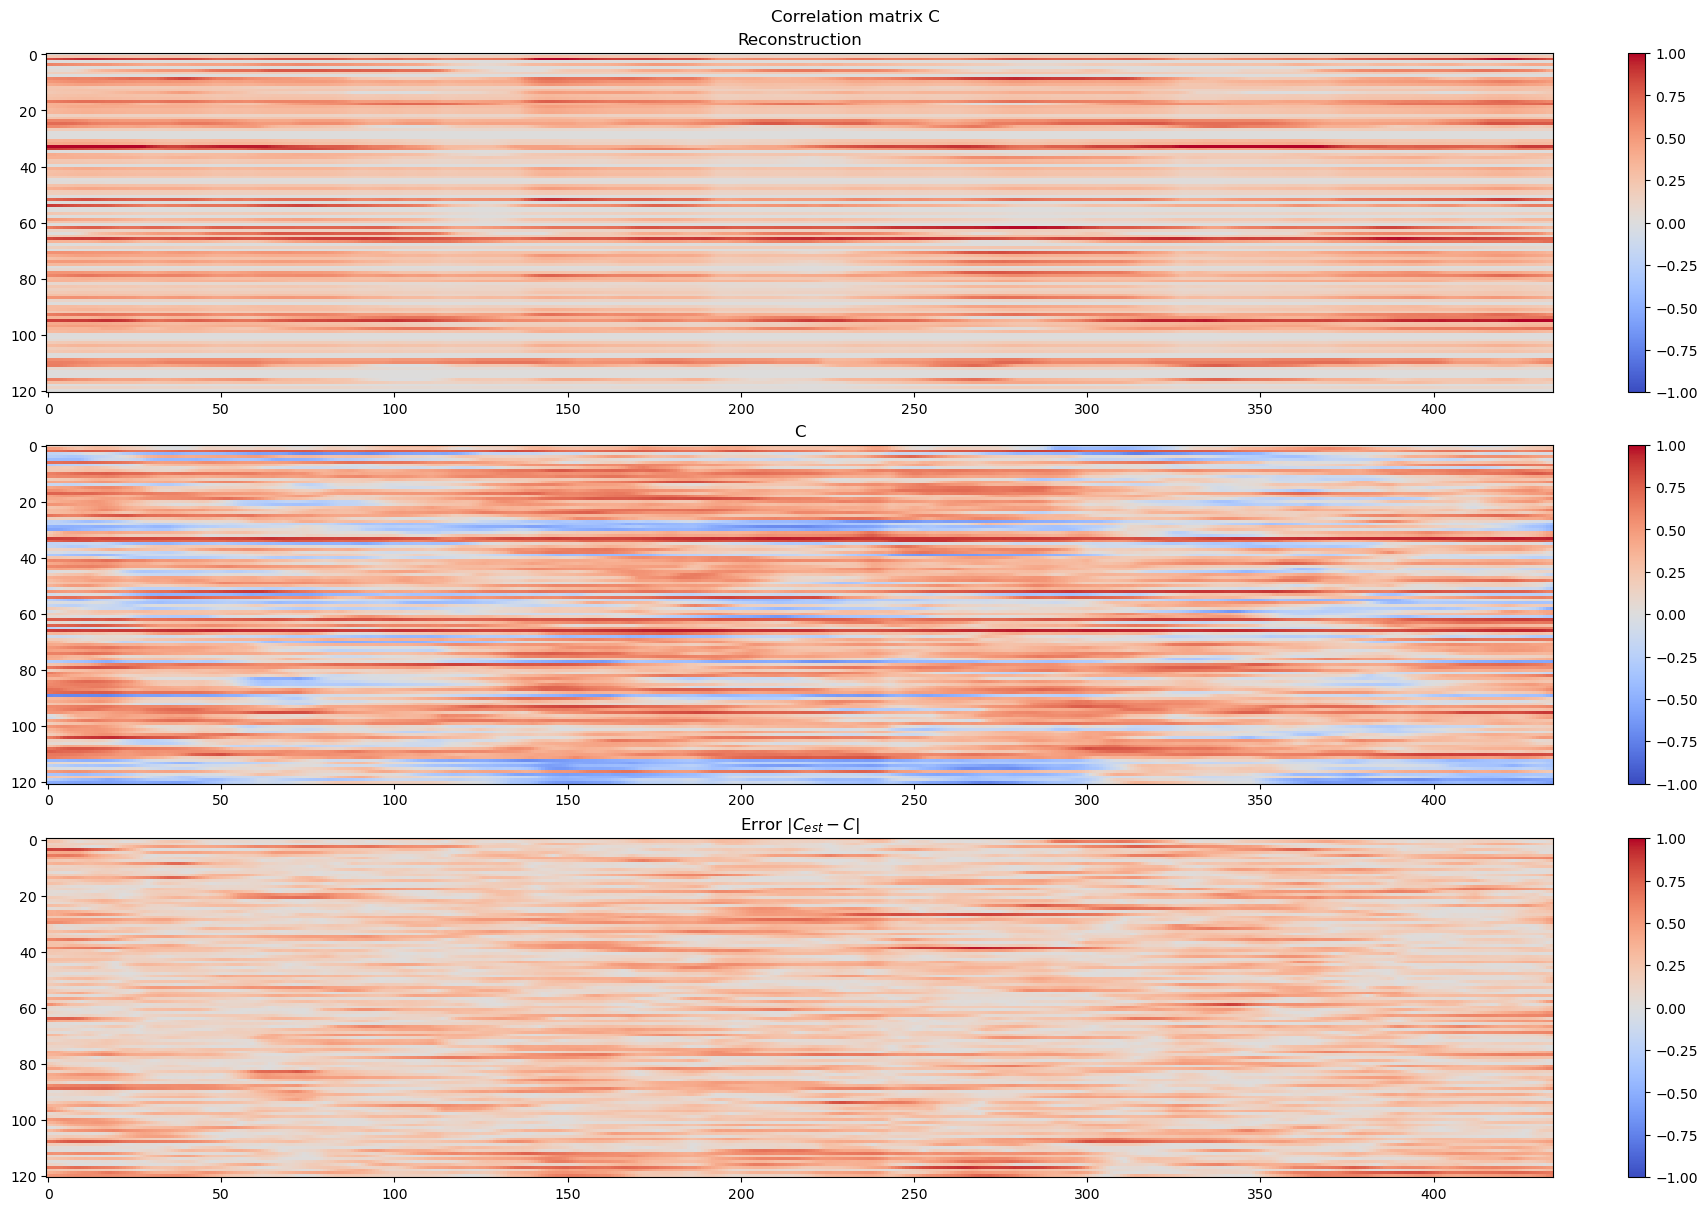

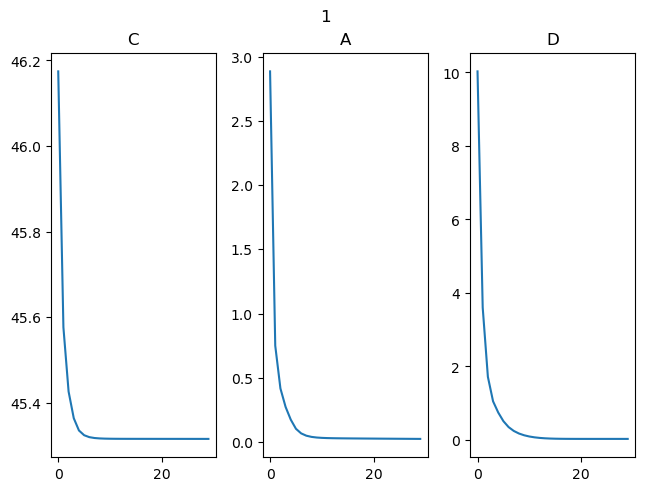

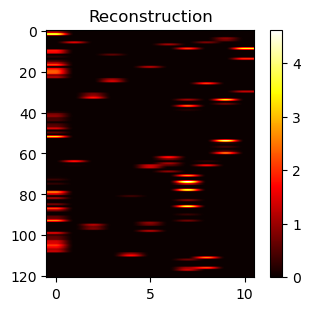

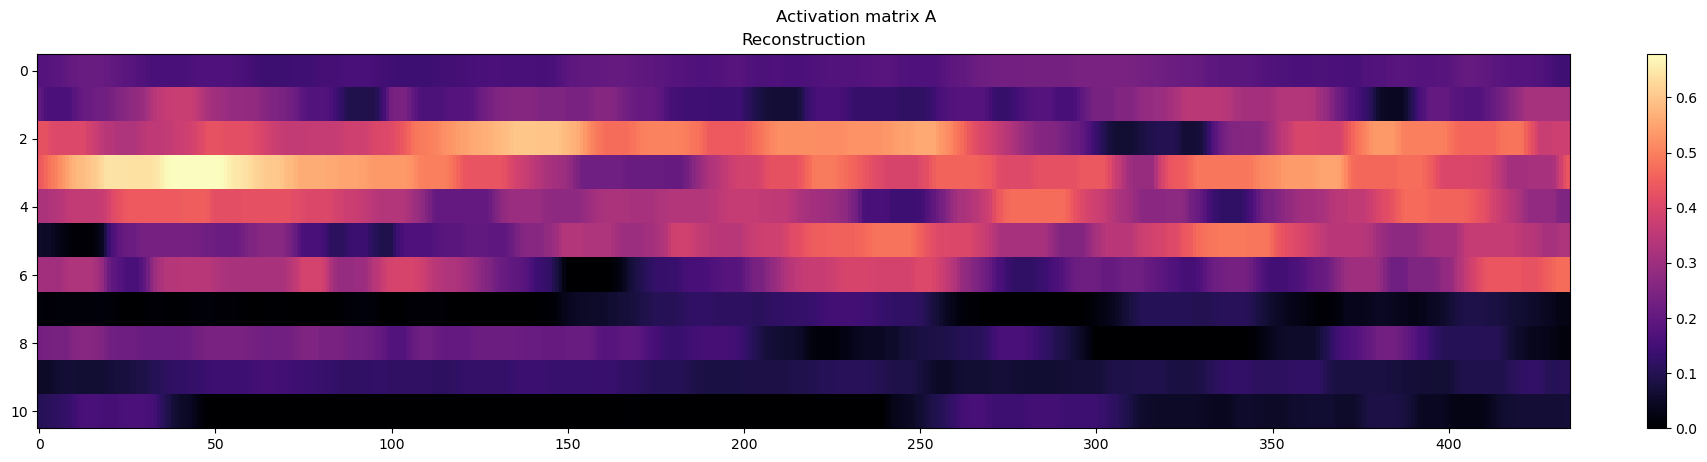

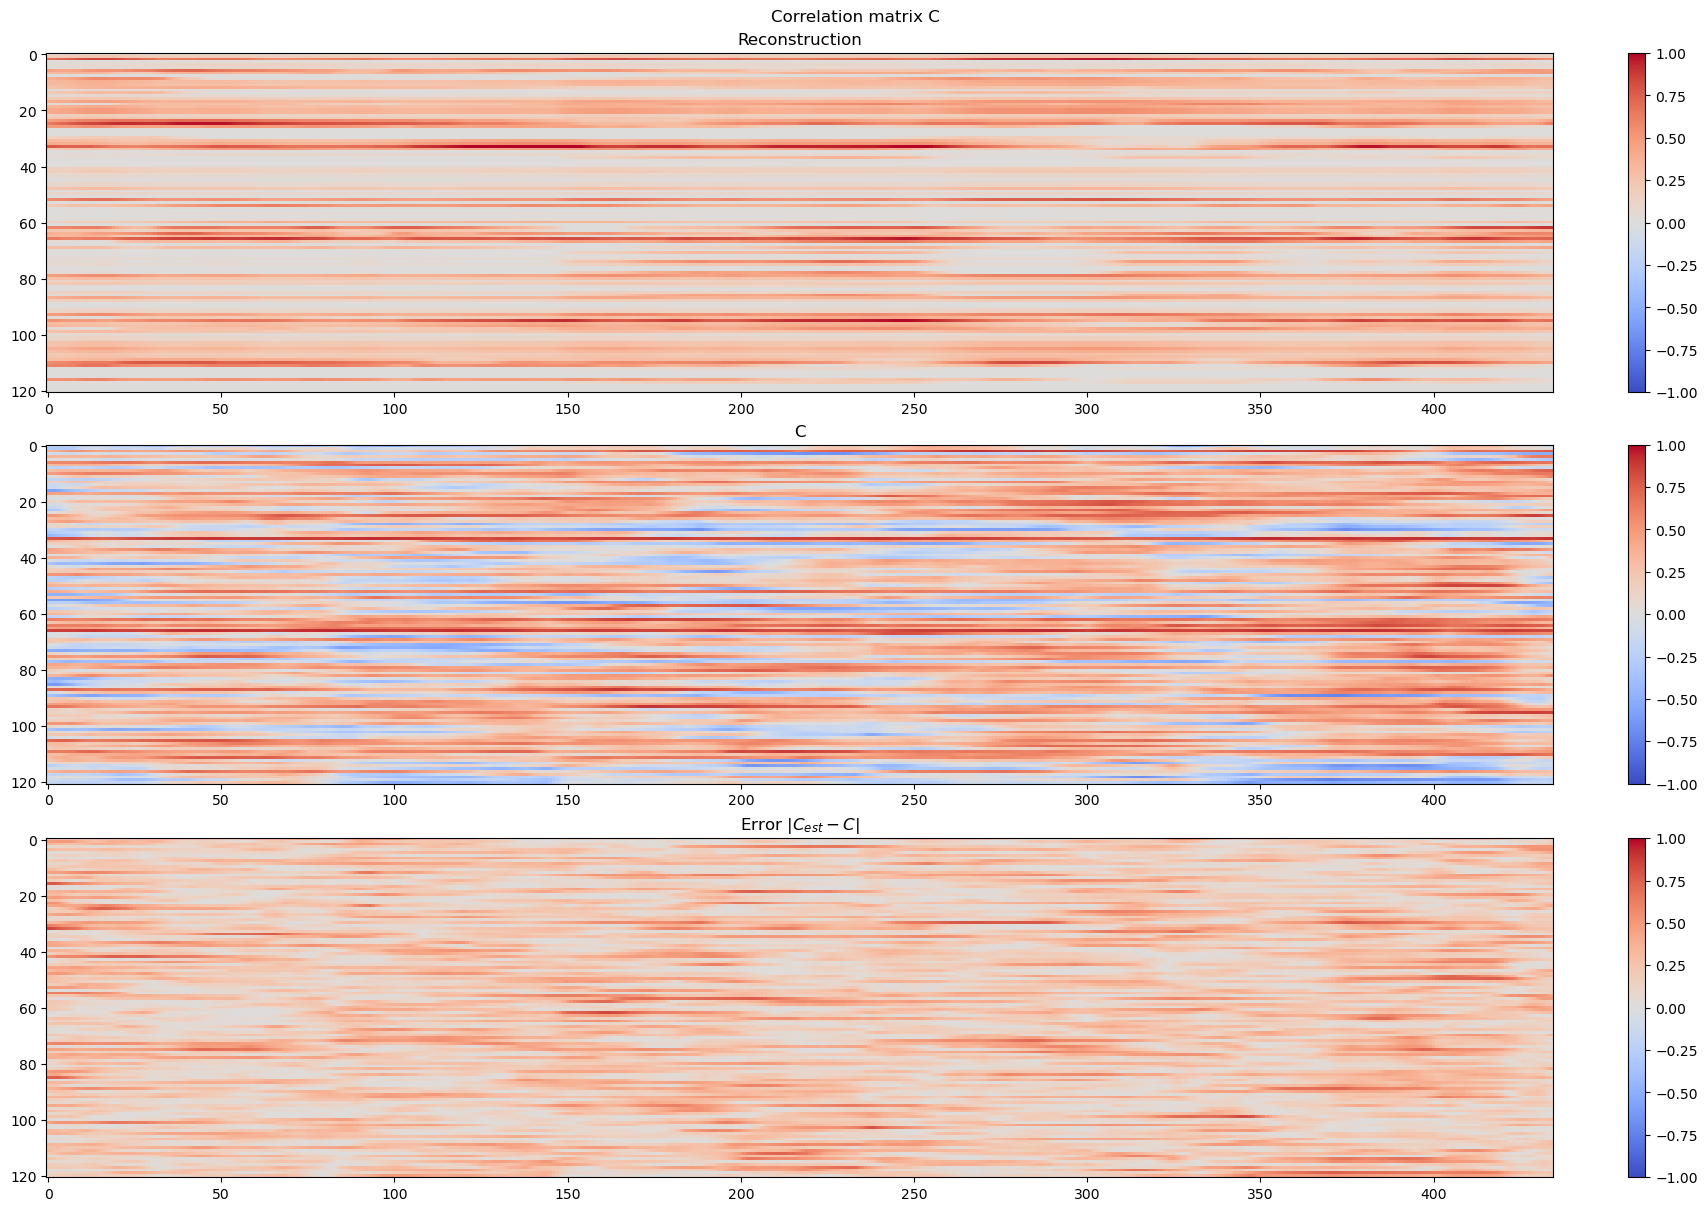

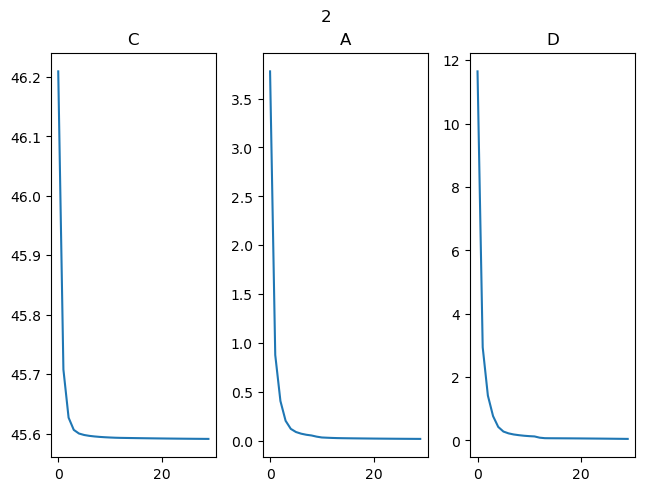

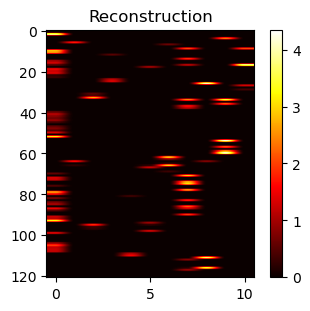

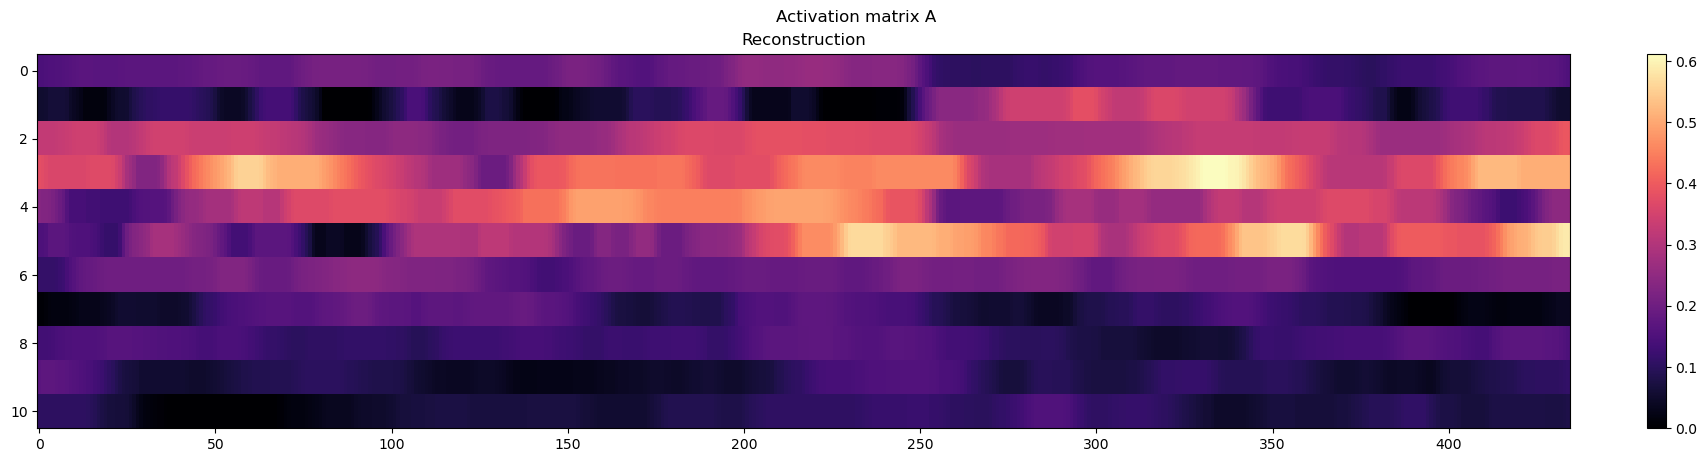

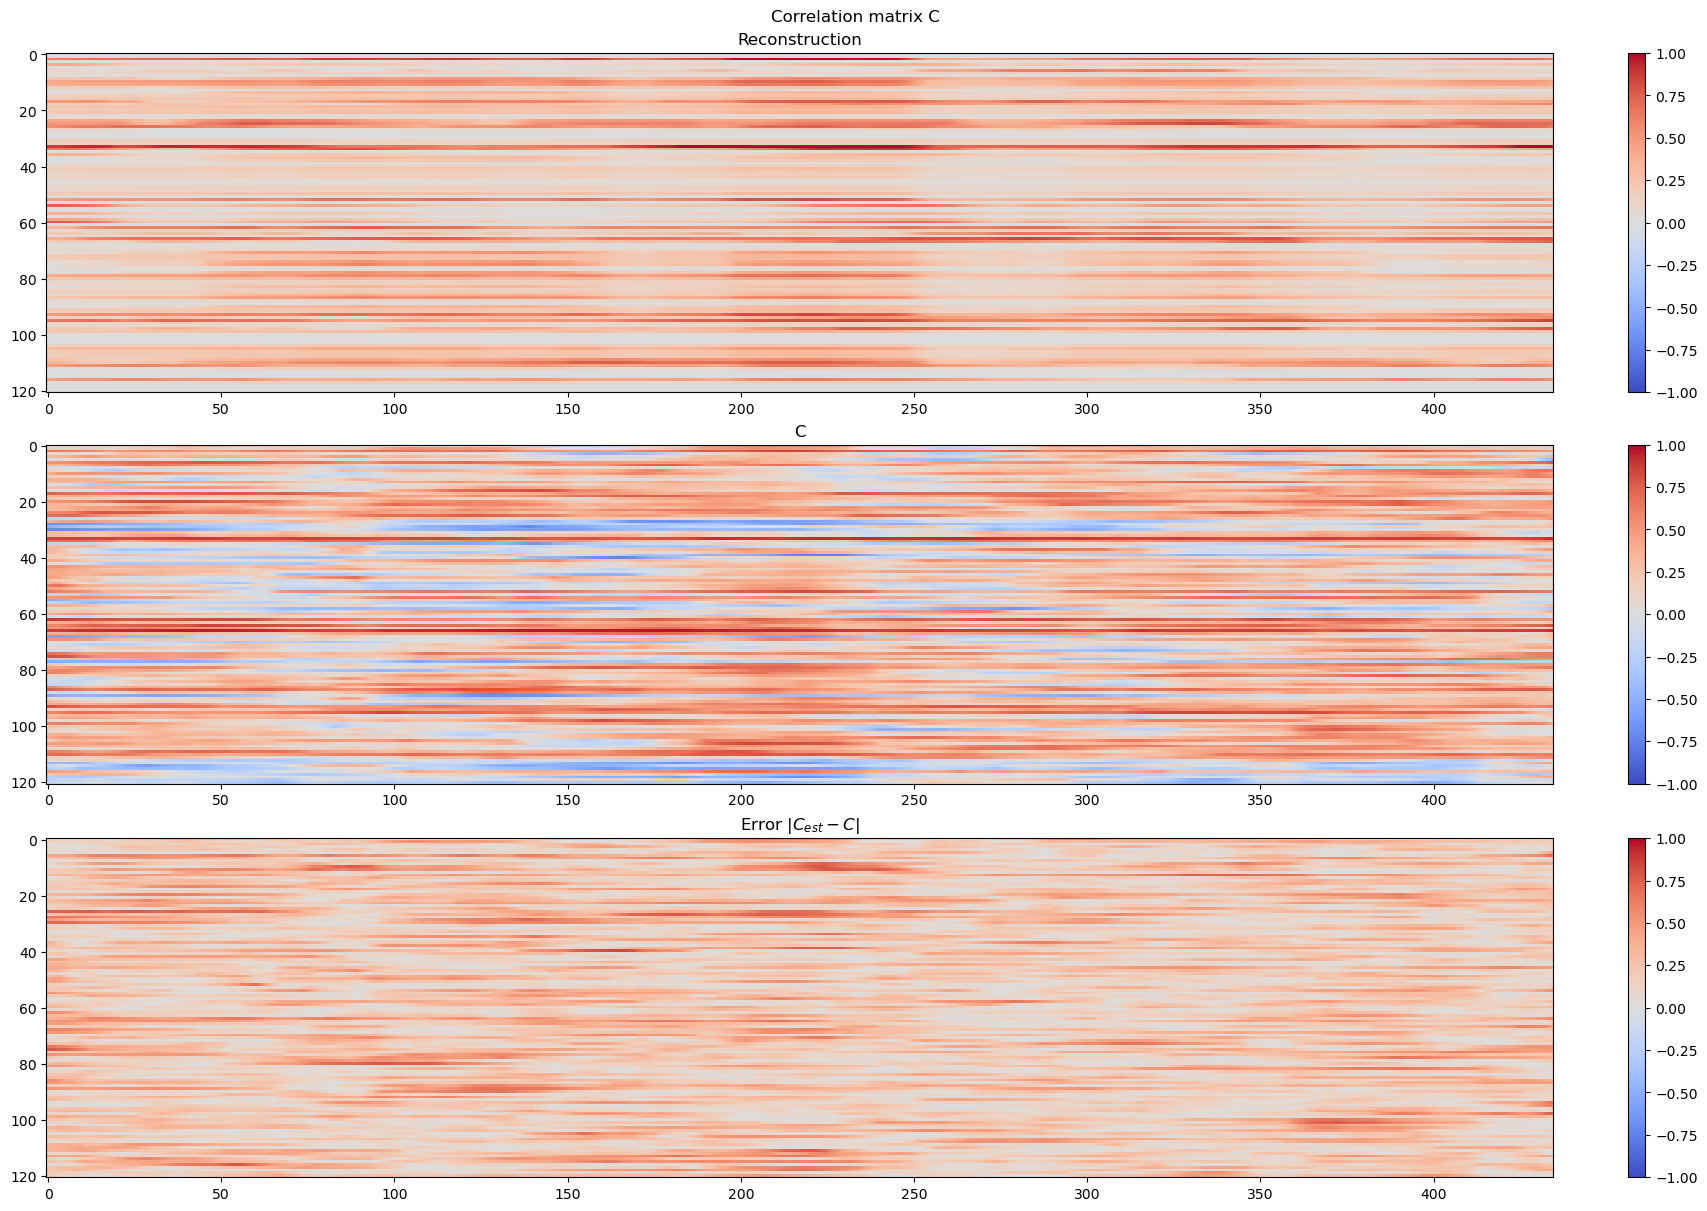

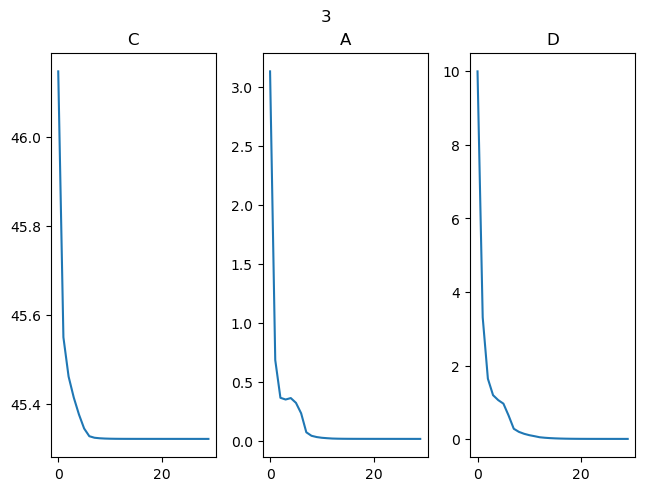

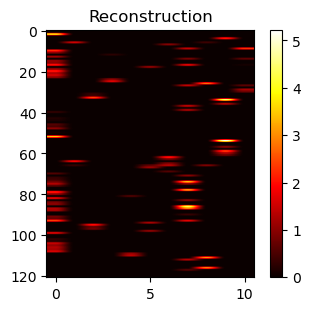

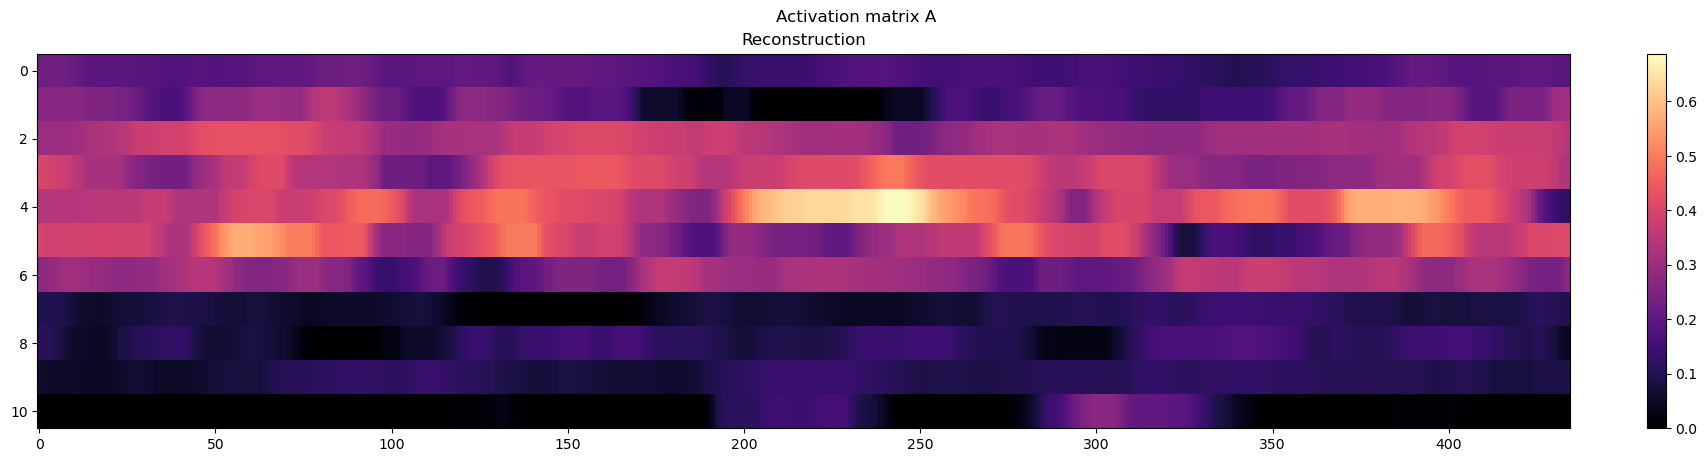

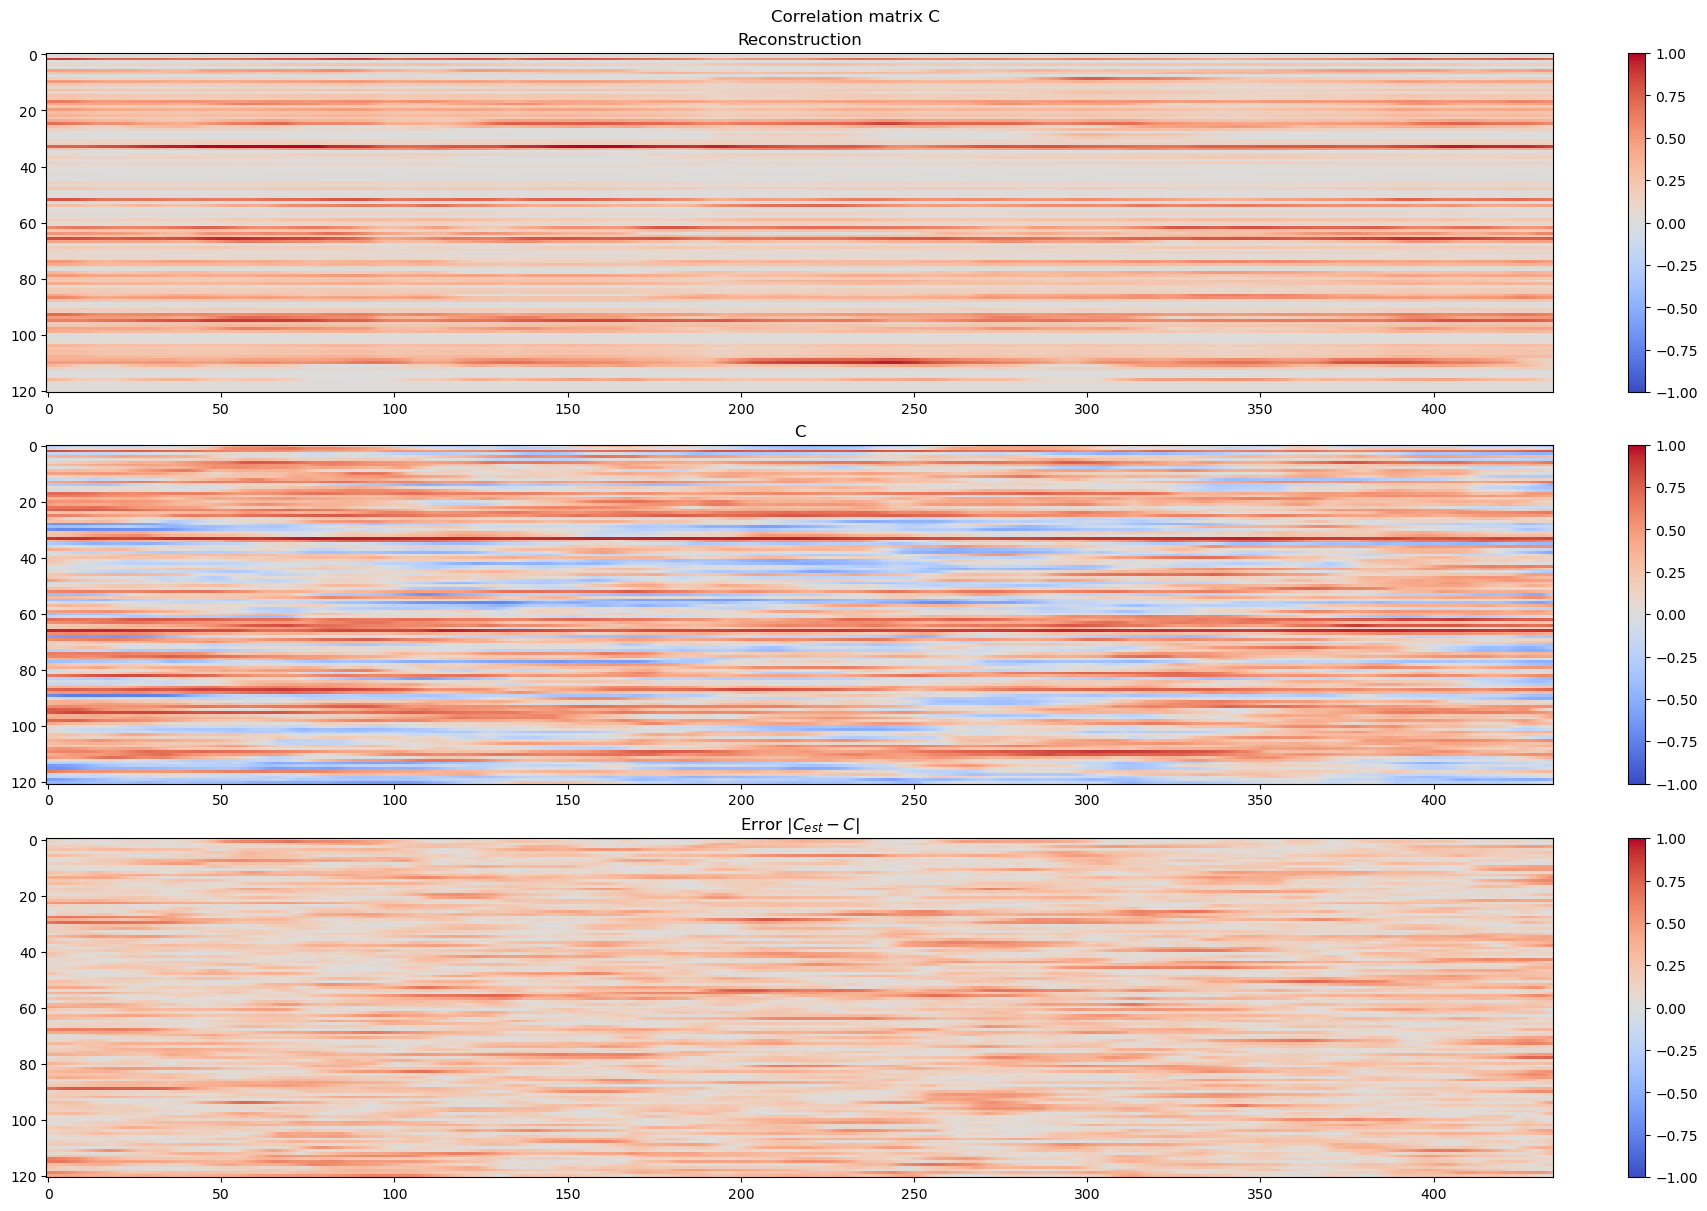

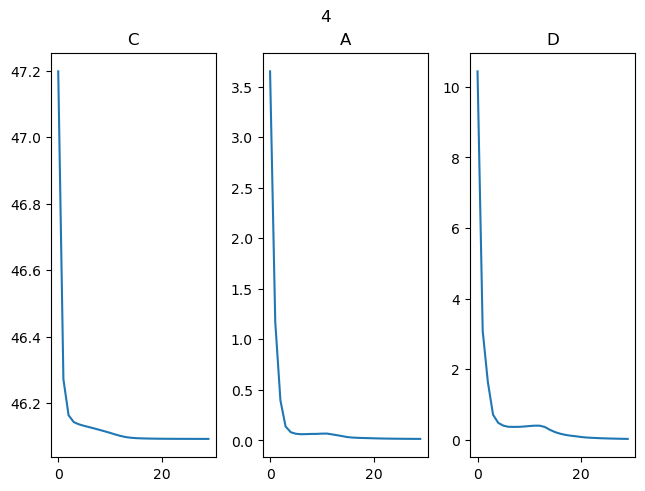

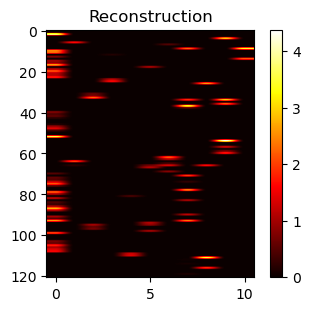

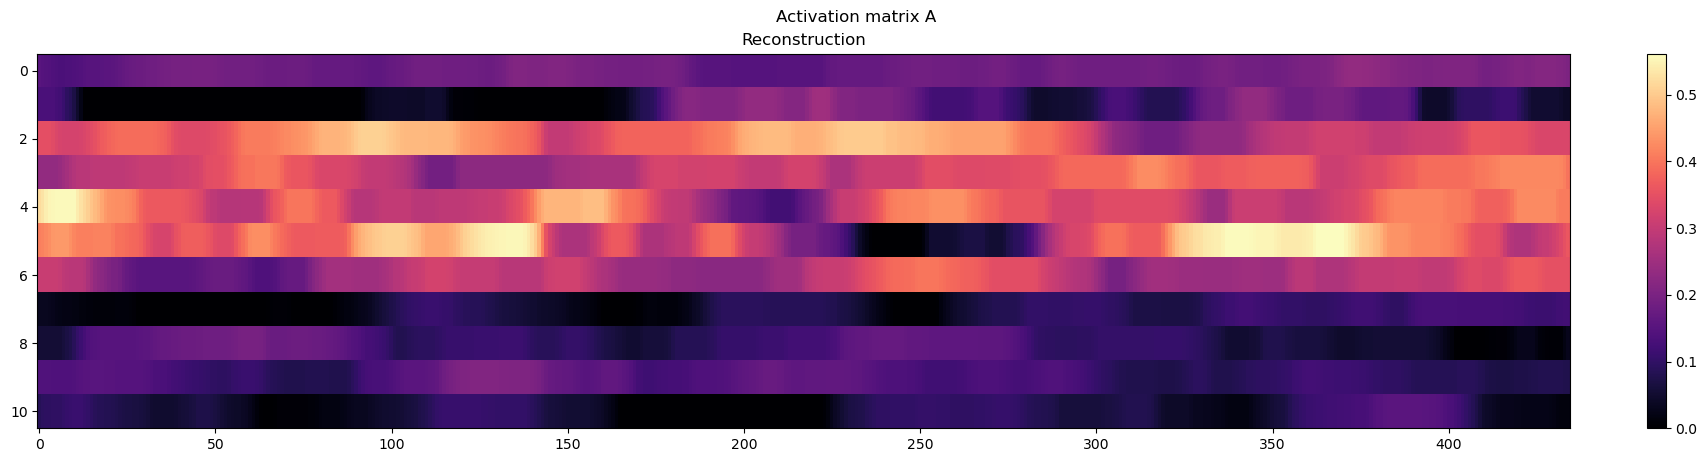

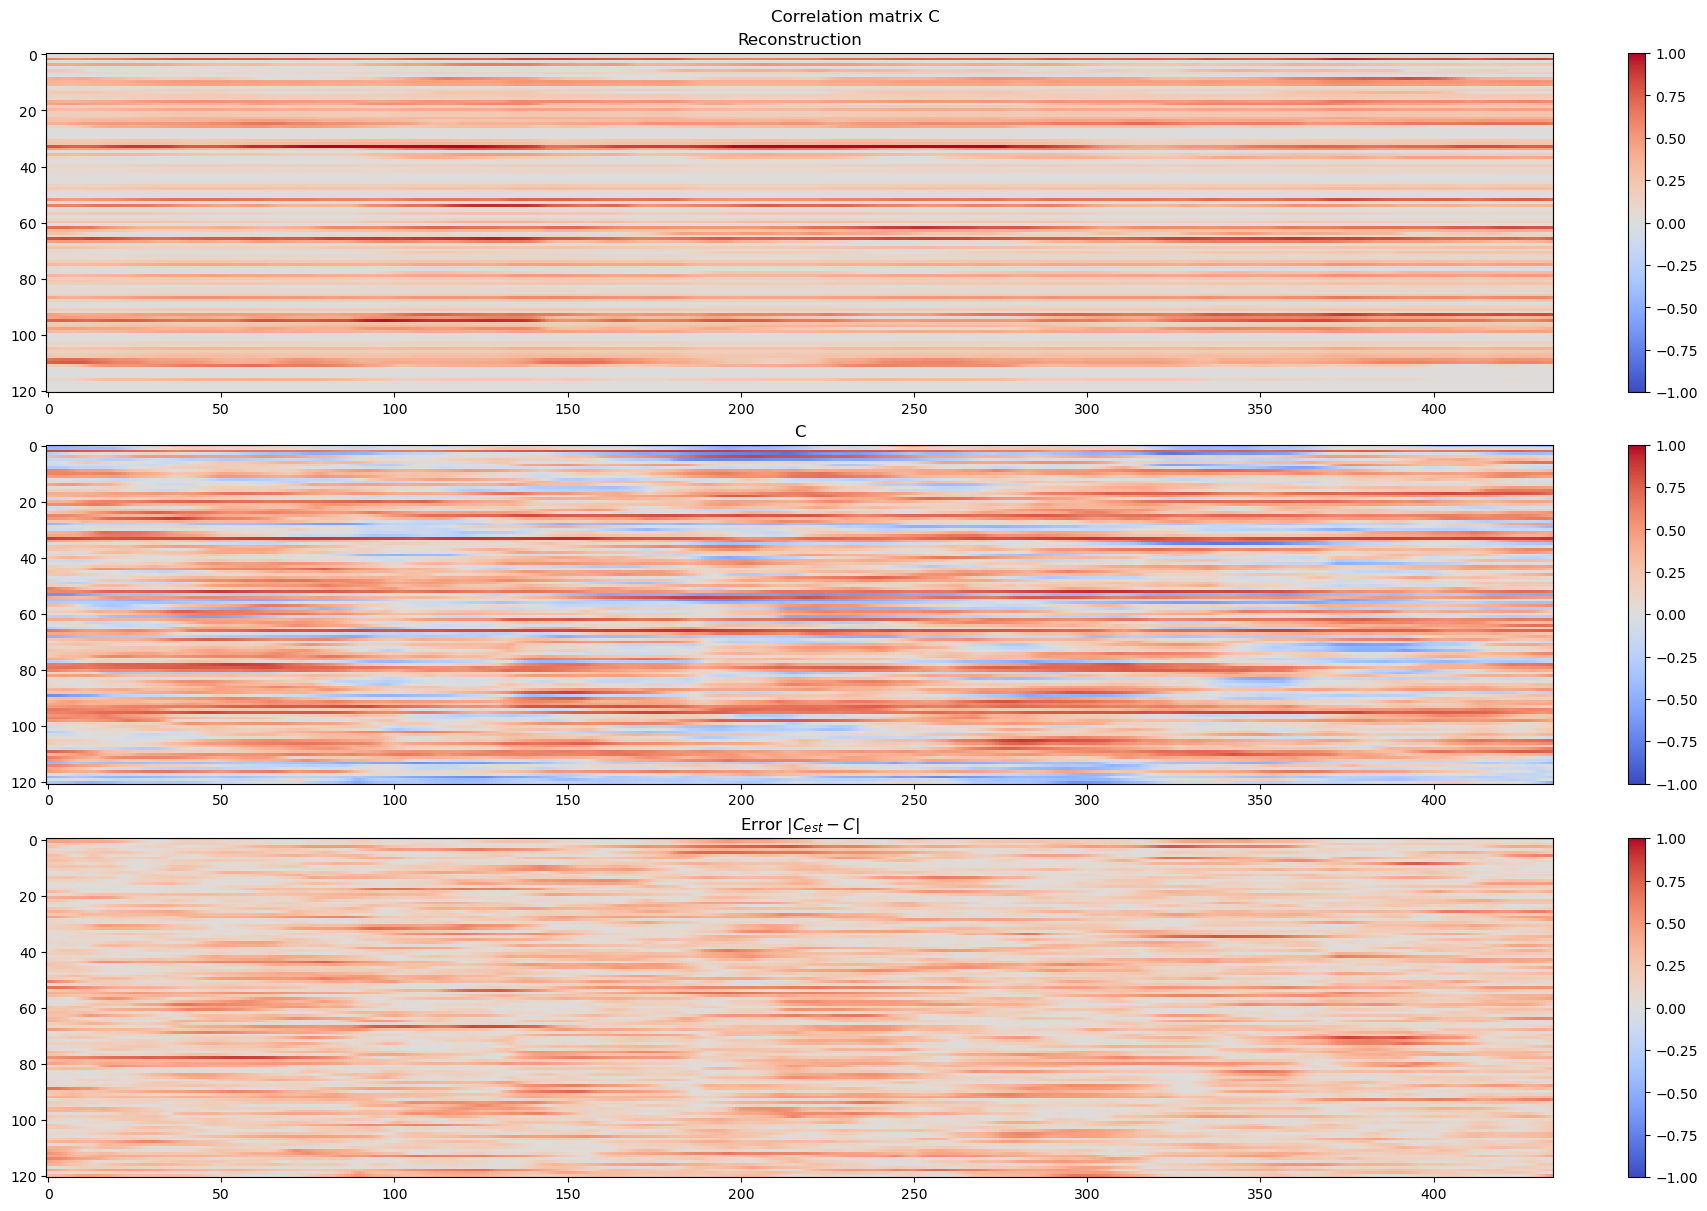

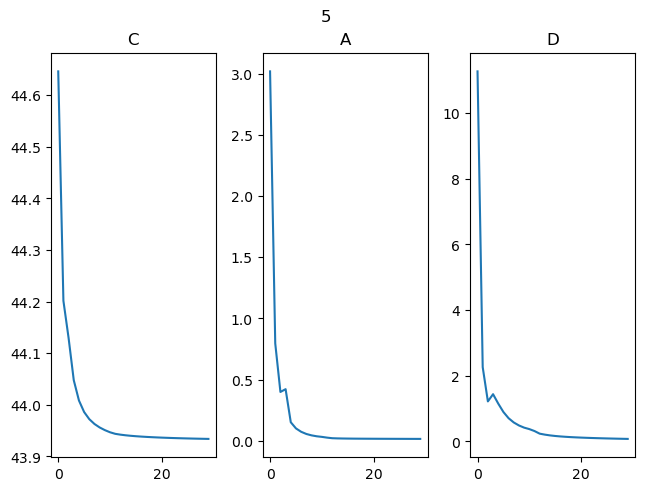

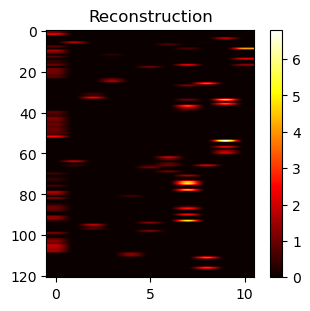

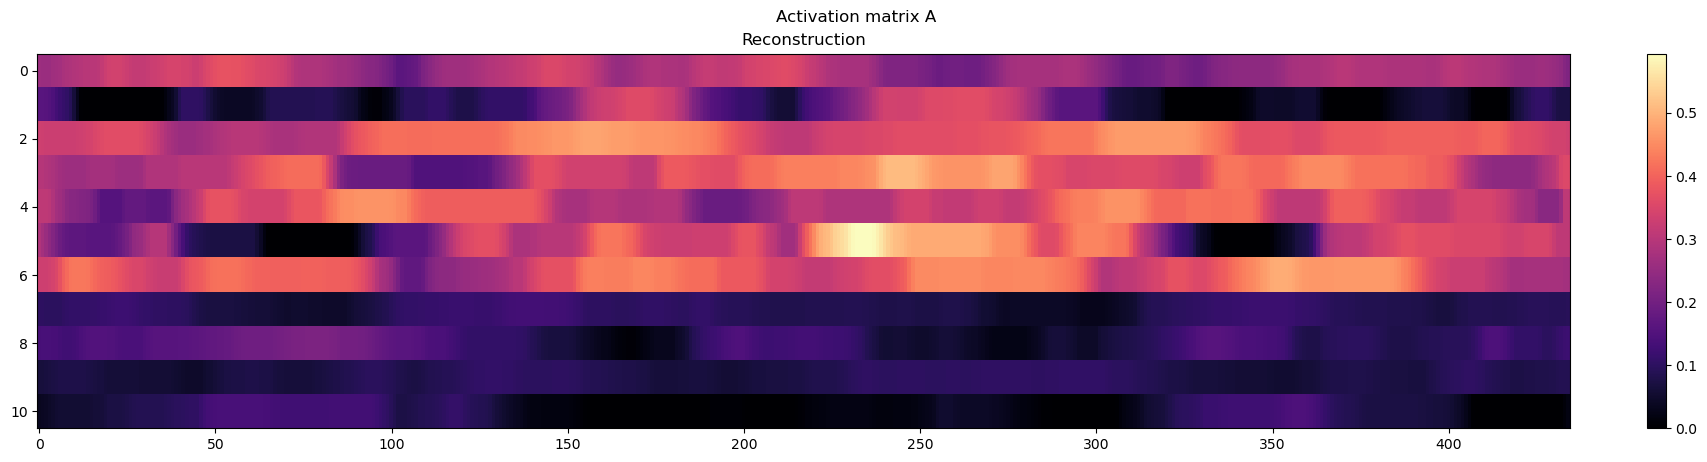

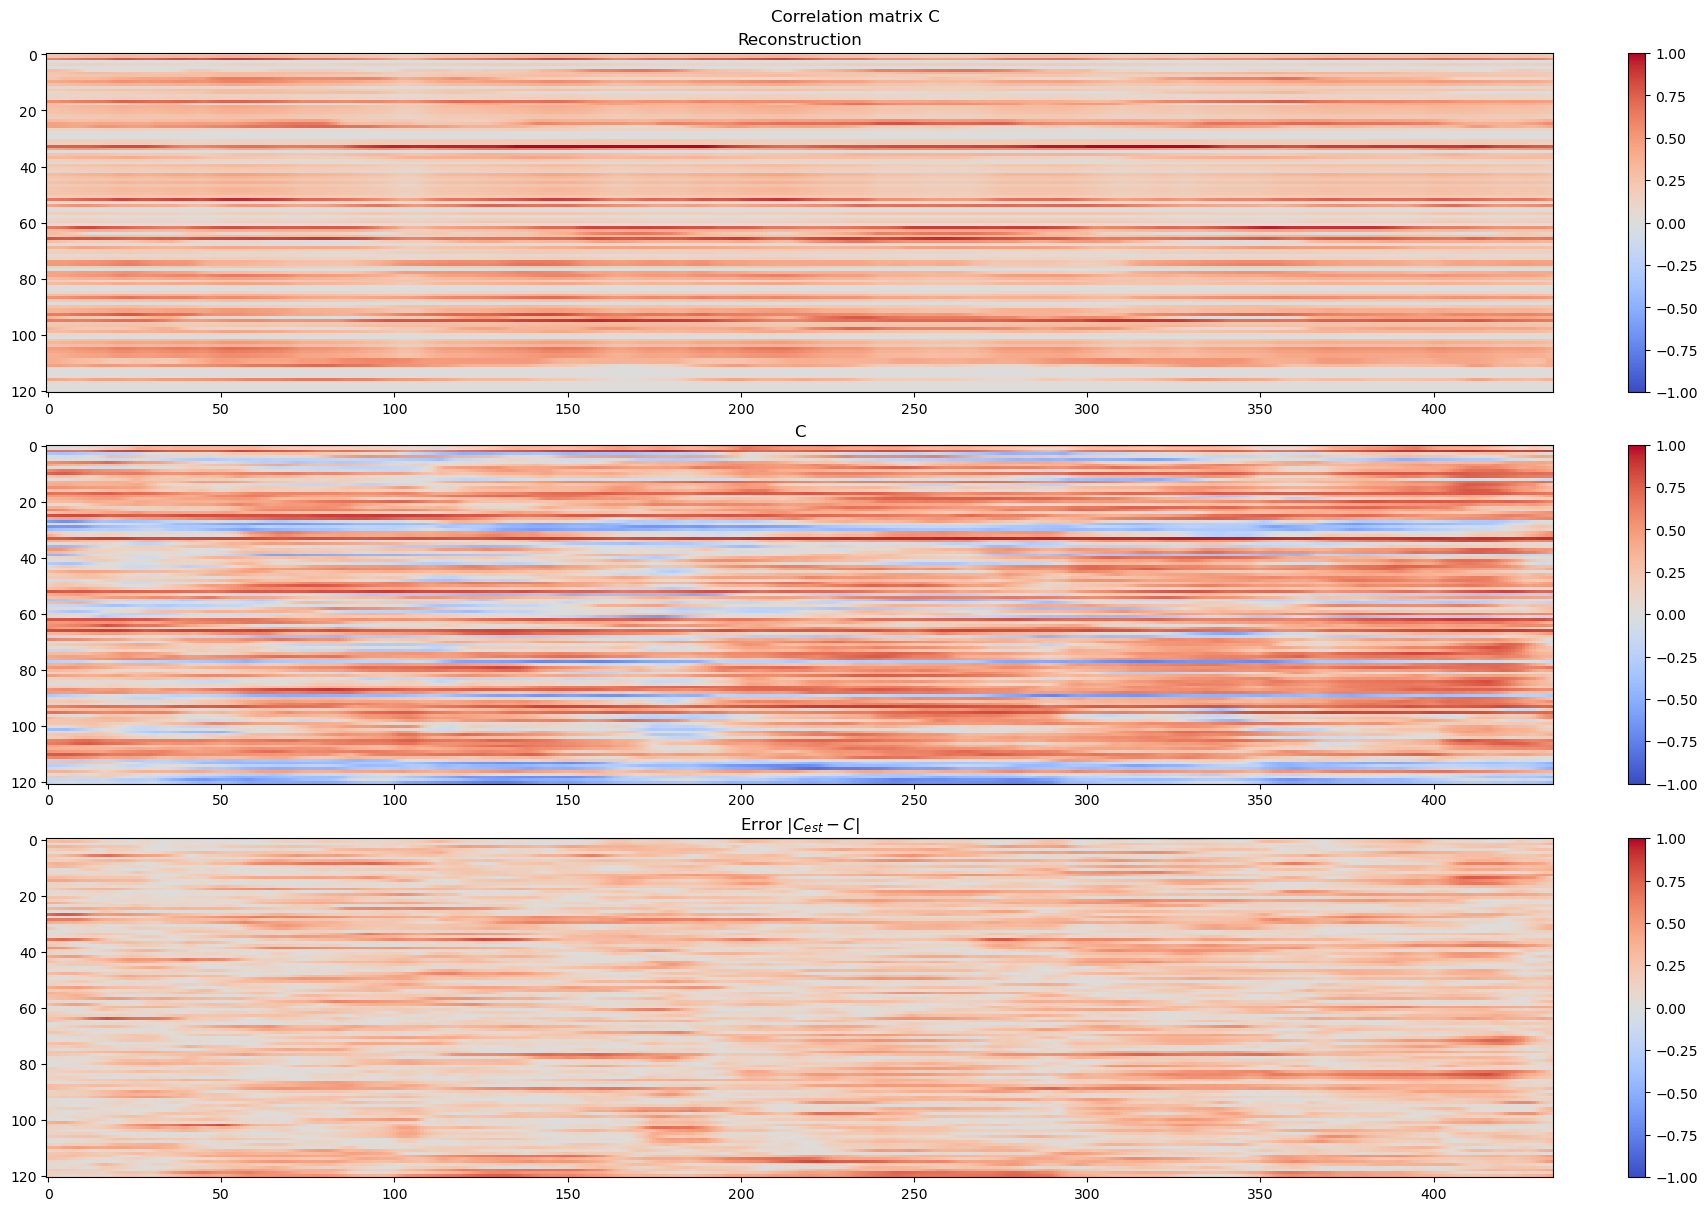

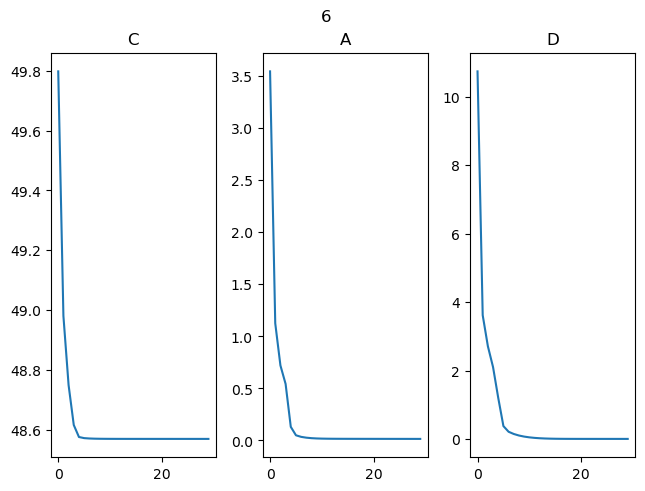

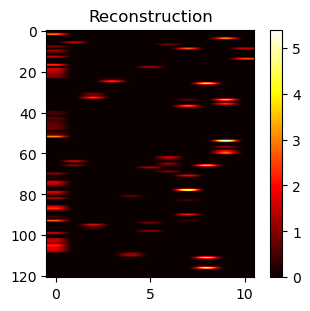

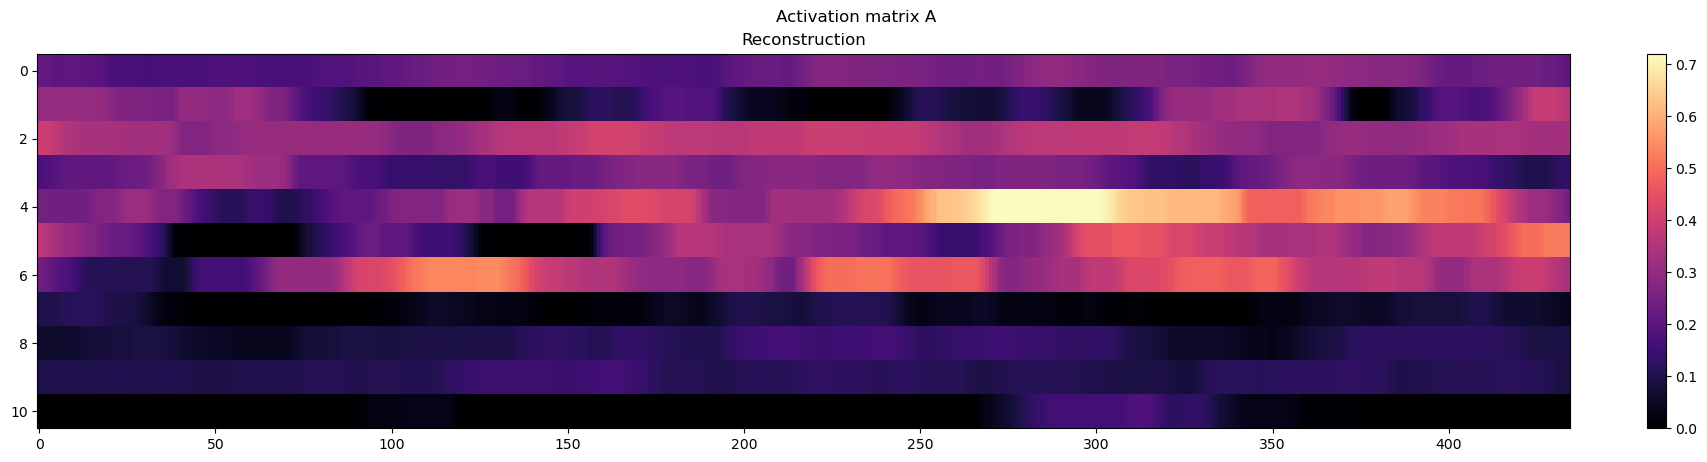

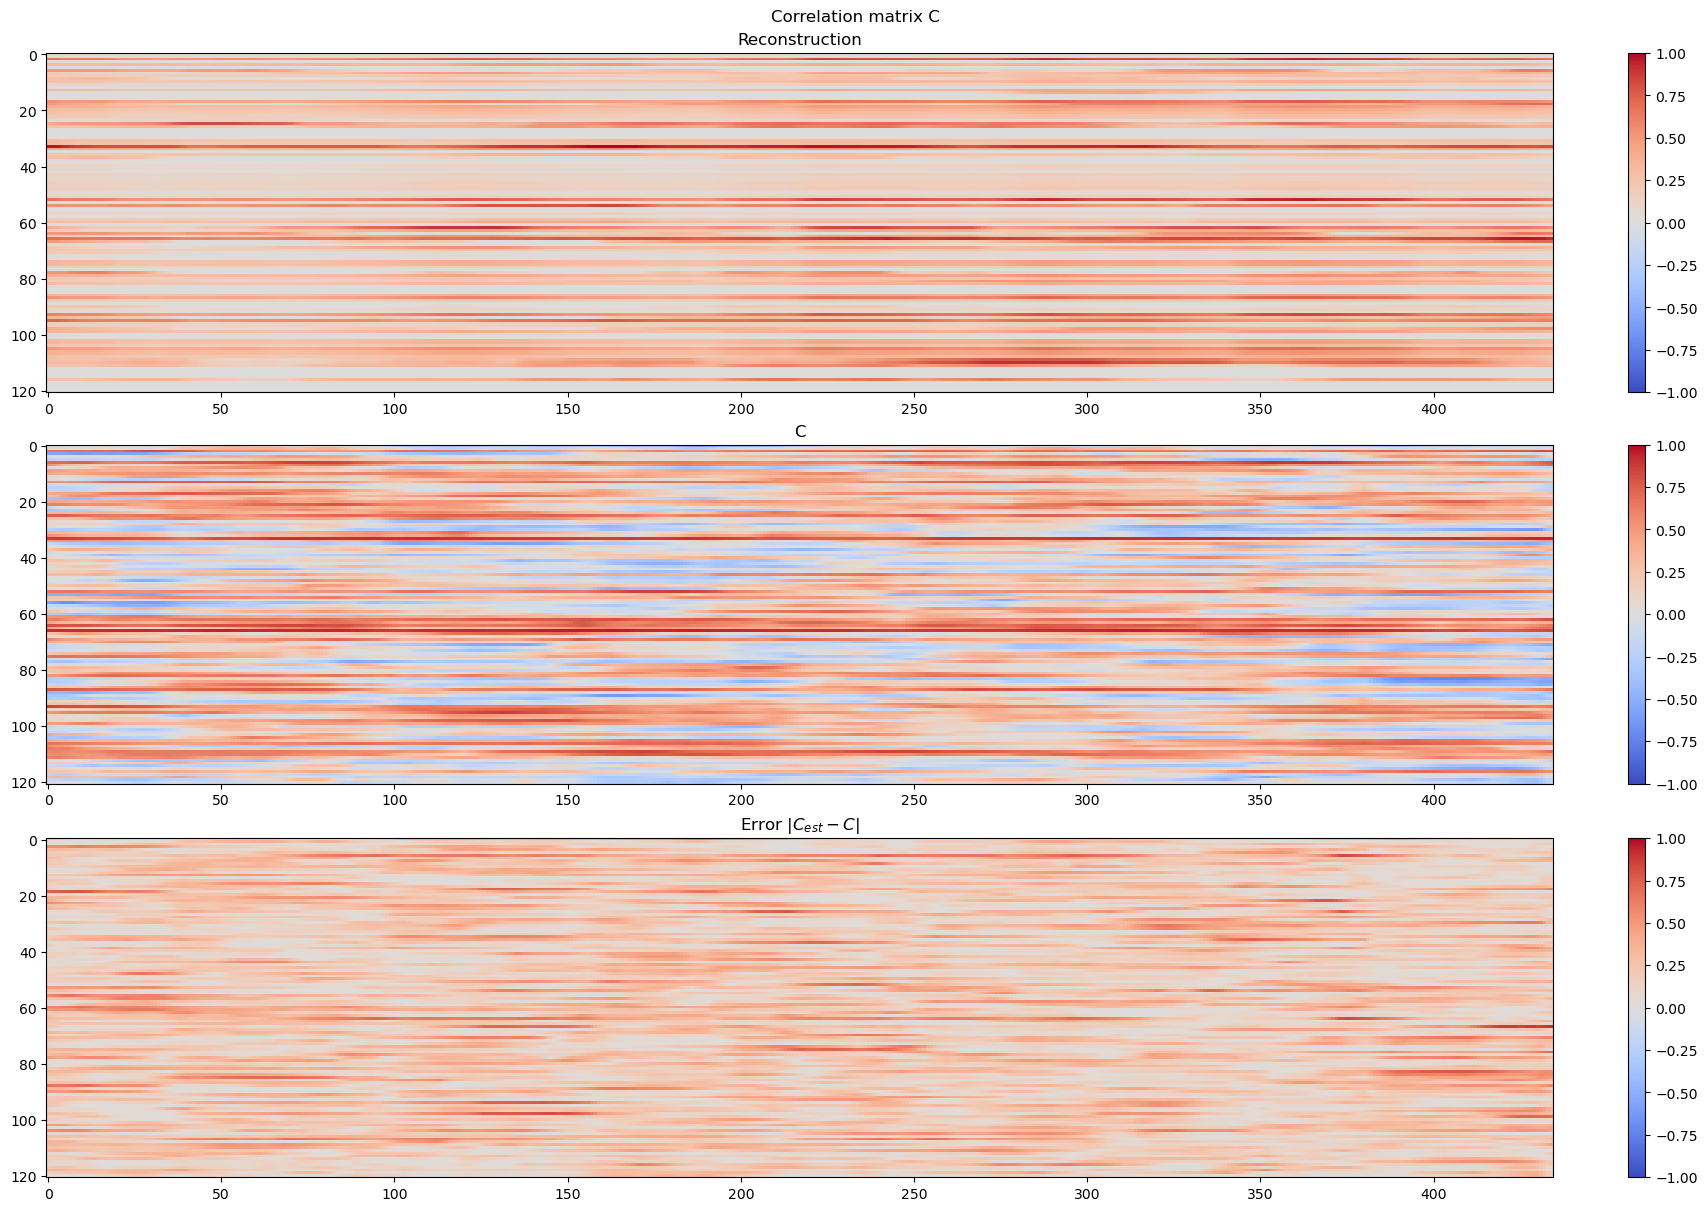

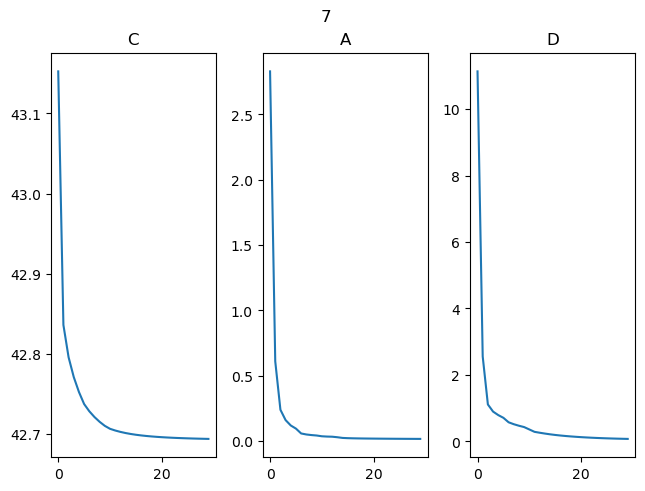

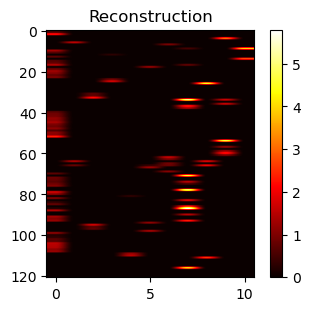

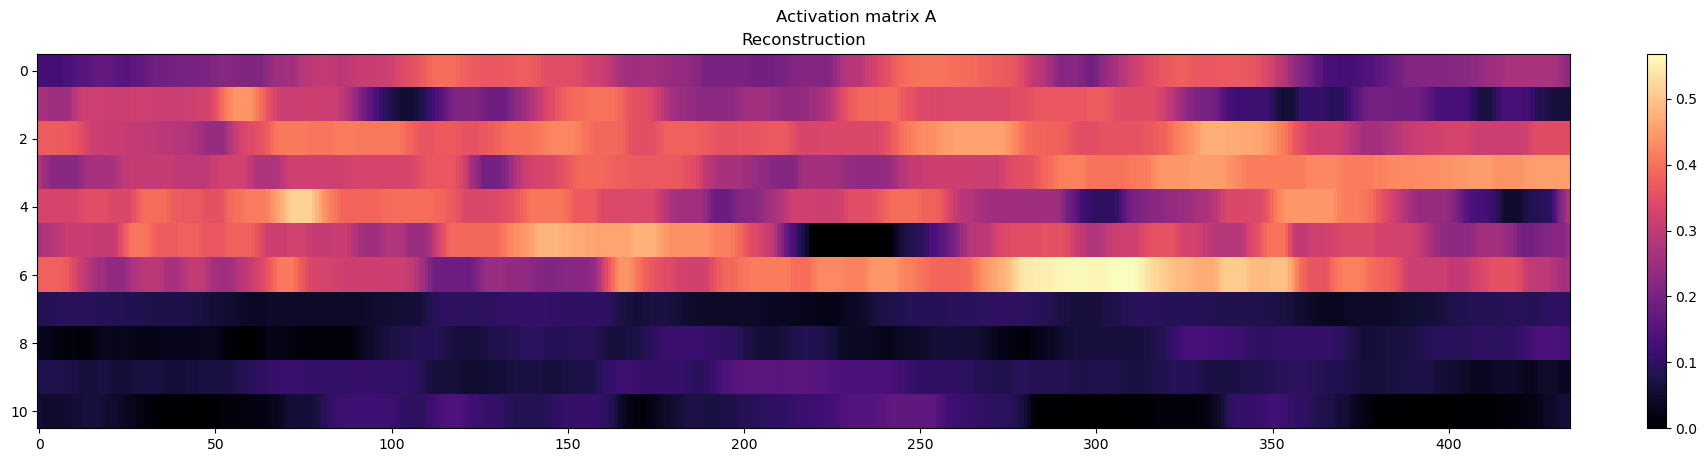

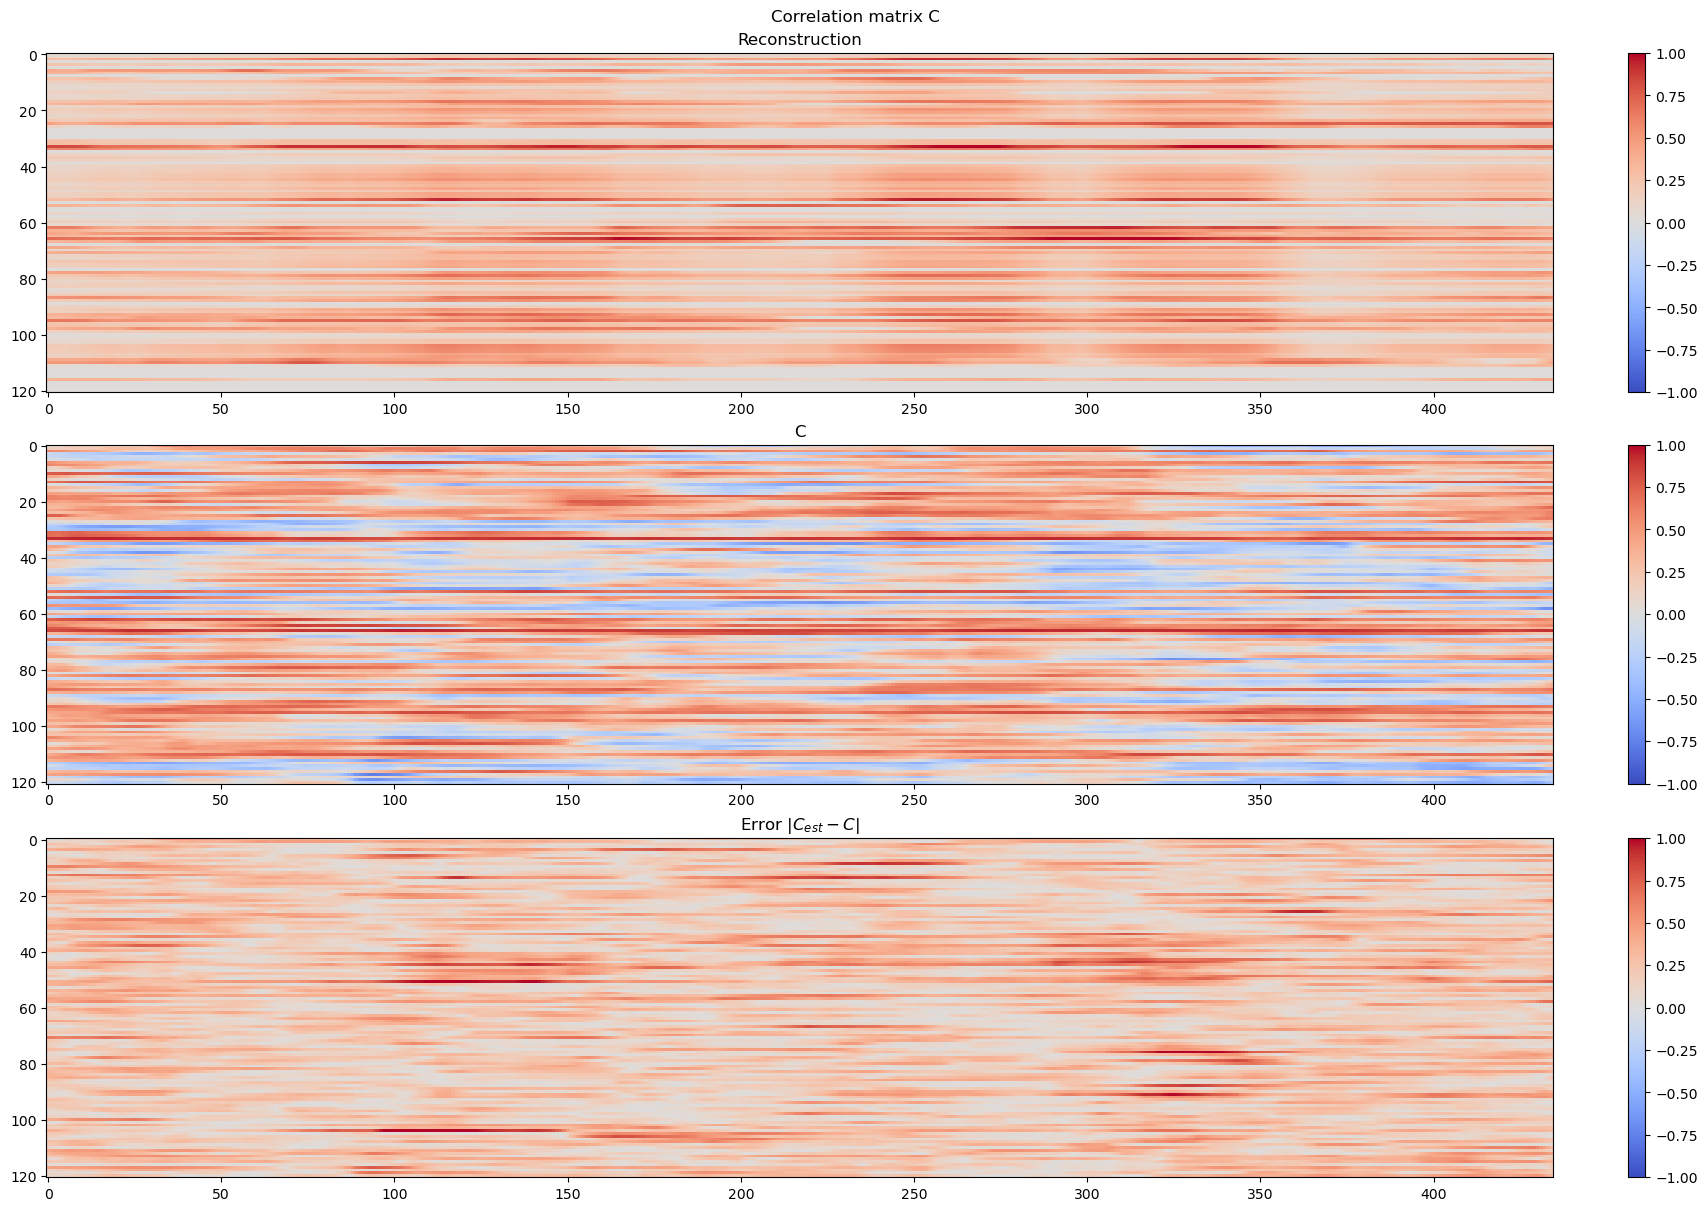

In [6]:
# display results

for s, result in enumerate(results_list):
    err = result["err"]
    plt.figure(layout ="constrained")
    plt.subplot(131)
    plt.plot(err[:, 0])
    plt.title("C")
    plt.subplot(132)
    plt.plot(err[: , 1])
    plt.title("A")
    plt.subplot(133)
    plt.plot(err[: , 2])
    plt.title("D")
    plt.suptitle(s)
    A_est = result["A_est"]
    D_est = result["D_est"]
    C_est =result["C_est"]
    plot_results(C_est, D_est, A_est,C = Cvec_list[s])
    


### Check the most active FCU

In [8]:
most_active_FCUs = np.zeros(Nb_subjects)

for s, result in enumerate(results_list):
    most_active_FCUs[s] = np.argmax(np.sum(result["A_est"], axis = 1))

In [9]:
FCU, count = np.unique(most_active_FCUs , return_counts=True)
active_FCU = int(FCU[np.argmax(count)])

In [13]:
#Display the most avtive FCU

#activation
A_active_FCU = np.zeros((Nb_subjects , N_windows))

for s, result in enumerate(results_list):
    A_active_FCU[s , :] = result["A_est"][active_FCU, :]

In [14]:
plt.rcParams.update({'font.size': 25})

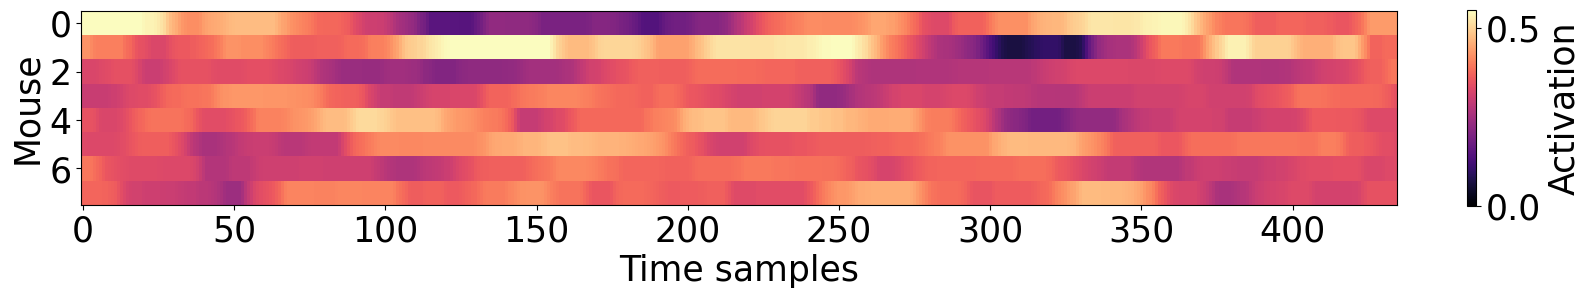

In [17]:
plt.figure(figsize=(18,4.5))
plt.imshow(A_active_FCU, aspect = 8, interpolation = 'nearest', cmap = 'magma', vmin = 0, vmax = 0.55)
plt.grid(False)
plt.ylabel("Mouse")
plt.xlabel("Time samples")
plt.yticks(np.arange(0, Nb_subjects, 2))
#plt.title(FCU_list[active_FCU])
plt.colorbar(label ="Activation" , fraction=0.007)
plt.savefig("./figs/fMRI/A_est_DMN_all.pdf")

### Check dictionary

In [14]:
D_active_FCU = np.zeros((E, Nb_subjects))

for s, result in enumerate(results_list):
    D_active_FCU[: , s] = result["D_est"][:, active_FCU]

In [12]:
plt.rcParams.update({'font.size': 23})

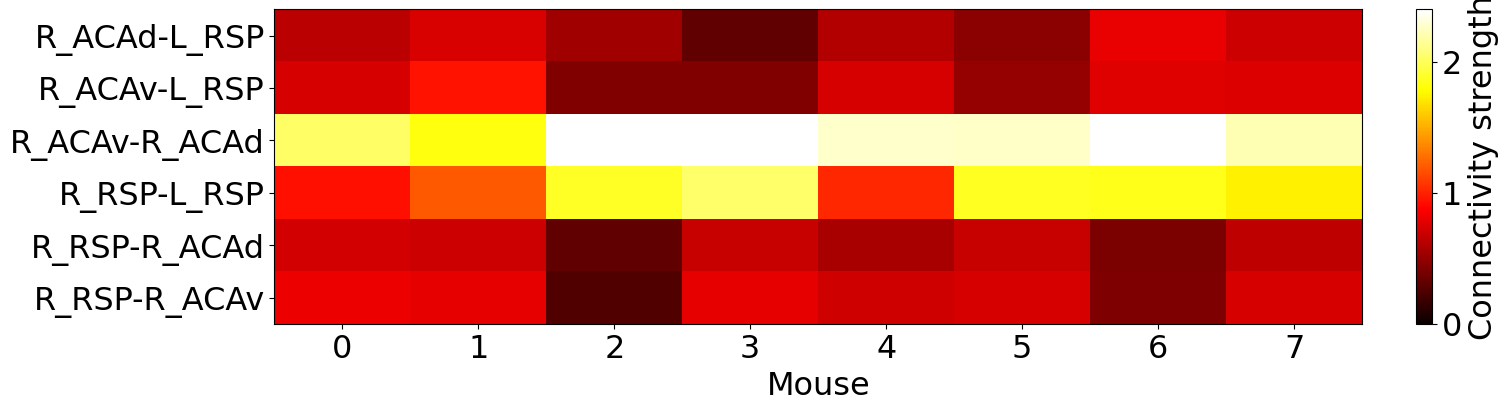

In [19]:
plt.figure(figsize=(15,4), layout = "constrained")
plt.imshow(D_active_FCU[D_tilde[:, active_FCU]==1,:], aspect = 'auto', interpolation = 'nearest', cmap = 'hot', vmin = 0, vmax = 2.4)
plt.grid(False)
plt.xlabel("Mouse")
#pairs= list(itertools.compress(ROI_pairs,D_tilde[:, active_FCU]))
pairs= ['-'.join(i) for i in itertools.compress(ROI_pairs,D_tilde[:, active_FCU])]
plt.yticks(np.arange(len(pairs)) , pairs)
#plt.ylabel("ROI pair")
plt.colorbar(label="Connectivity strength")
#plt.title("Dictionary column of active ROI pairs in most active FCU per subject")
#plt.savefig("./figs/fMRI/D_est_DMN_all.pdf")
plt.show()

### Check total activation of FCUs

In [17]:
total_activation_FCU =  np.zeros(( Nb_subjects, P))

for s, result in enumerate(results_list):
    total_activation_FCU[s , :] = np.mean(result["A_est"] , axis = 1)

In [43]:
plt.rcParams.update({'font.size': 25})

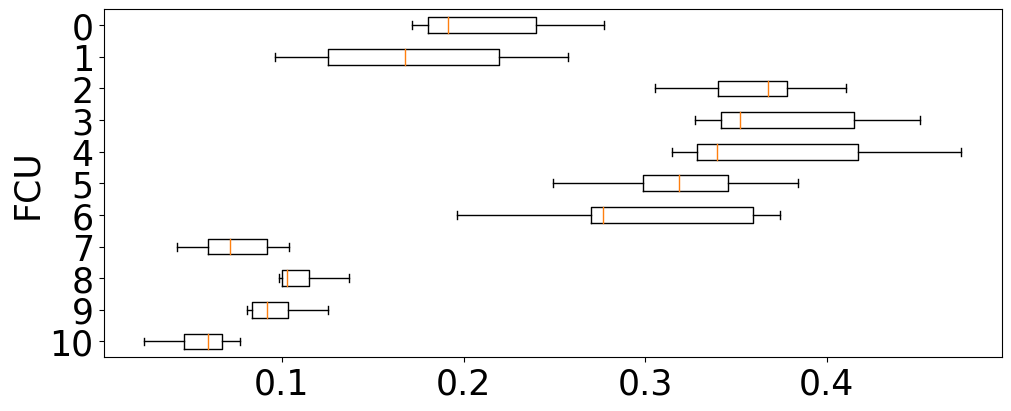

In [45]:
# Hide FCU names
plt.figure(layout ="constrained", figsize=(10, 4))
plt.boxplot(np.fliplr(total_activation_FCU) , vert=False, labels = np.flip(np.arange(P)) ,sym="");
plt.ylabel("FCU")
plt.savefig("./figs/fMRI/FCU_total_activation.pdf")